In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import sklearn


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, LSTM, Input,SpatialDropout1D, GlobalMaxPool1D, MaxPooling1D, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn import model_selection
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, precision_score, accuracy_score, recall_score, f1_score
from tensorflow.keras.optimizers import Adam

In [2]:
# 5. Membaca file CSV ke dalam DataFrame
import pandas as pd
df = pd.read_csv('dataset_50k.csv')
df.head()

Unnamed: 0  Label                                         detokenize
0           0      1  aku luka diri aku jalan hidup sulit orang tua ...
1           1      0   buang pikir negatif laku gelisah milik putus asa
2           2      1  jujur aku takut mati aku orang aku sulit paham...
3           3      0              saya mes pasang sepatu jam saya harap
4           4      1  capek hati banget aku allah aku kayak mata ora...

In [3]:
df = df.dropna()
df

Unnamed: 0  Label                                         detokenize
0               0      1  aku luka diri aku jalan hidup sulit orang tua ...
1               1      0   buang pikir negatif laku gelisah milik putus asa
2               2      1  jujur aku takut mati aku orang aku sulit paham...
3               3      0              saya mes pasang sepatu jam saya harap
4               4      1  capek hati banget aku allah aku kayak mata ora...
...           ...    ...                                                ...
50518       50518      0  curi rampok liar begal rakyat senantiasa resah...
50519       50519      0                      saya bicara saya buat tertawa
50520       50520      1  sakit sakit guna sakit bahagia sakit bohong or...
50521       50521      1                              lantai lantai gelisah
50522       50522      1  aku tulis catat kemarin kata tunang aku laku b...

[50523 rows x 3 columns]

In [4]:
df['label'] = df['Label'].apply(lambda x: 0 if x == 0 else 1)
df.head()

Unnamed: 0  Label                                         detokenize  label
0           0      1  aku luka diri aku jalan hidup sulit orang tua ...      1
1           1      0   buang pikir negatif laku gelisah milik putus asa      0
2           2      1  jujur aku takut mati aku orang aku sulit paham...      1
3           3      0              saya mes pasang sepatu jam saya harap      0
4           4      1  capek hati banget aku allah aku kayak mata ora...      1

<BarContainer object of 2 artists>

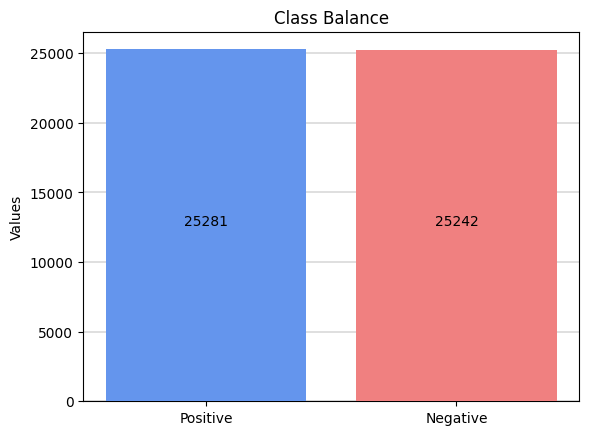

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]//2, y[i], ha = 'center',zorder=4)

# Count the values in the 'Label' column
count = df['Label'].value_counts()
x = ["Positive", "Negative"]  # Custom labels for class balance plot
y = [count[1], count[0]]
addlabels(x,y)
plt.ylabel("Values")
plt.title('Class Balance')
plt.grid(color='dimgray', linewidth=0.3, axis='y',zorder=0)
plt.bar(x,y, color= ['cornflowerblue', 'lightcoral'], zorder=3)

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vektorisasi teks menggunakan TF-IDF bigram)
vectorizer = TfidfVectorizer(min_df=10, ngram_range=(3,3), max_df=0.7, max_features=10000)

# Menggunakan fit_transform untuk mengubah dokumen menjadi fitur
vector = vectorizer.fit_transform(df['detokenize']).toarray()
tf_idf_len = len(vectorizer.vocabulary_)

In [7]:
#Split data 80% data train and 20% data test
x_unigram = pd.DataFrame(vector)
label = df["Label"]
x_train, x_test, y_train, y_test =  model_selection.train_test_split(x_unigram,label, test_size = 0.1)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(45470, 5170) (45470,)
(5053, 5170) (5053,)


In [8]:
y_train

48714    0
45211    1
907      1
2278     0
41958    0
        ..
35649    0
10239    1
28822    0
12654    0
33027    0
Name: Label, Length: 45470, dtype: int64

In [9]:
x_train = np.array(x_train).reshape(-1, 1, x_train.shape[1])
x_test = np.array(x_test).reshape(-1, 1, x_test.shape[1])

In [10]:
x_train

array([[[0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.]]])

In [11]:
x_train.shape

(45470, 1, 5170)

In [12]:
import matplotlib.pyplot as plt

def make_plot(history, train, validation, title):
    graph = plt.plot(history.history[train], lw=2.0)
    graph = plt.plot(history.history[validation], lw=2.0)
    graph = plt.title(title)
    graph = plt.legend(['training', 'validasi'])
    graph = plt.show()

    return graph

In [13]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Membuat model hybrid lstm-cnn
def hybrid_lstm_cnn(x_train, y_train, x_test, y_test):


    model = Sequential()
    model.add(Input(shape=(1,x_train.shape[2])))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2, strides=1, padding='same'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy',optimizer=optimizer ,metrics=['accuracy'])
    print(model.summary())

    history = model.fit(x_train, y_train, epochs = 10, validation_data=(x_test, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)] )

    #Membuat plot garis akurasi
    make_plot(history, "accuracy", "val_accuracy", "Perubahan Akurasi tiap epoch")

    #predict
    predictions = model.predict(x_test)
    print()
    print("Classification Report :")
    print(classification_report(y_test, predictions.round(), digits=6))


    acc_score = accuracy_score(y_test, predictions.round())
    prec_score = precision_score(y_test, predictions.round())
    rec_score = recall_score(y_test, predictions.round())
    f1score = f1_score(y_test, predictions.round())

    return [acc_score,prec_score,rec_score,f1score ]


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ spatial_dropout1d (SpatialDropout1D) │ (None, 1, 5170)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 1, 128)              │       2,713,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 1, 128)              │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,799,297 (10.68 MB)

 Trainable params: 2,799,297 (10.68 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.6468 - loss: 0.6025 - val_accuracy: 0.7307 - val_loss: 0.5053
Epoch 2/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.7300 - loss: 0.5020 - val_accuracy: 0.7322 - val_loss: 0.5014
Epoch 3/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.7297 - loss: 0.4927 - val_accuracy: 0.7326 - val_loss: 0.4973
Epoch 4/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.7354 - loss: 0.4825 - val_accuracy: 0.7320 - val_loss: 0.5016
Epoch 5/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.7367 - loss: 0.4811 - val_accuracy: 0.7326 - val_loss: 0.5036
Epoch 6/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.7380 - loss: 0.4793 - val_accuracy: 0.7330 - val_loss: 0.5110


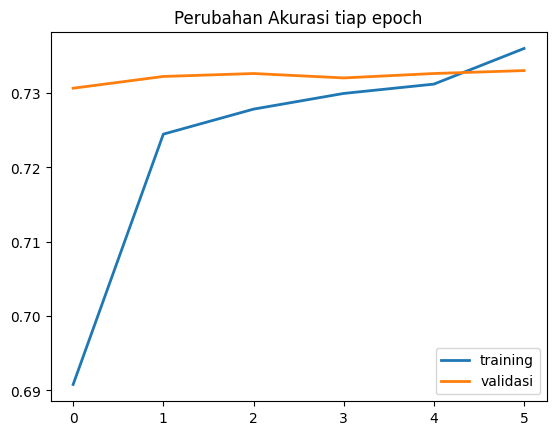

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Classification Report :
              precision    recall  f1-score   support

           0   0.679176  0.878282  0.766002      2514
           1   0.830189  0.589208  0.689242      2539

    accuracy                       0.733030      5053
   macro avg   0.754682  0.733745  0.727622      5053
weighted avg   0.755056  0.733030  0.727432      5053



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ spatial_dropout1d_1                  │ (None, 1, 5170)             │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 1, 128)              │       2,713,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 1, 128)              │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,799,297 (10.68 MB)

 Trainable params: 2,799,297 (10.68 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.6438 - loss: 0.6044 - val_accuracy: 0.7301 - val_loss: 0.5065
Epoch 2/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.7290 - loss: 0.5020 - val_accuracy: 0.7338 - val_loss: 0.4999
Epoch 3/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.7255 - loss: 0.4934 - val_accuracy: 0.7312 - val_loss: 0.5011
Epoch 4/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.7347 - loss: 0.4862 - val_accuracy: 0.7305 - val_loss: 0.5033
Epoch 5/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.7305 - loss: 0.4856 - val_accuracy: 0.7322 - val_loss: 0.5032


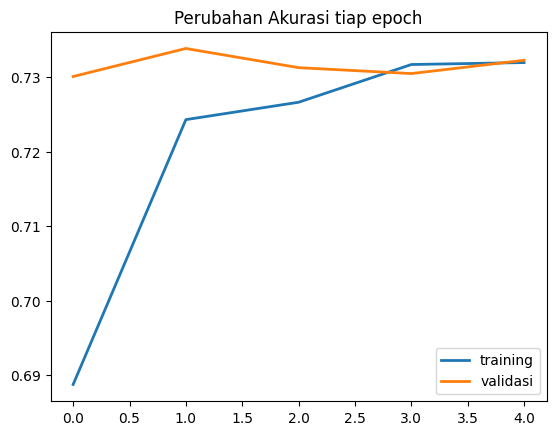

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Classification Report :
              precision    recall  f1-score   support

           0   0.678891  0.876293  0.765063      2514
           1   0.827987  0.589602  0.688751      2539

    accuracy                       0.732238      5053
   macro avg   0.753439  0.732947  0.726907      5053
weighted avg   0.753807  0.732238  0.726718      5053



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ spatial_dropout1d_2                  │ (None, 1, 5170)             │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 1, 128)              │       2,713,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 1, 128)              │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,799,297 (10.68 MB)

 Trainable params: 2,799,297 (10.68 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.6383 - loss: 0.6038 - val_accuracy: 0.7299 - val_loss: 0.5041
Epoch 2/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.7252 - loss: 0.5061 - val_accuracy: 0.7338 - val_loss: 0.4990
Epoch 3/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.7301 - loss: 0.4930 - val_accuracy: 0.7332 - val_loss: 0.4998
Epoch 4/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.7330 - loss: 0.4857 - val_accuracy: 0.7316 - val_loss: 0.4993
Epoch 5/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.7347 - loss: 0.4820 - val_accuracy: 0.7334 - val_loss: 0.5004


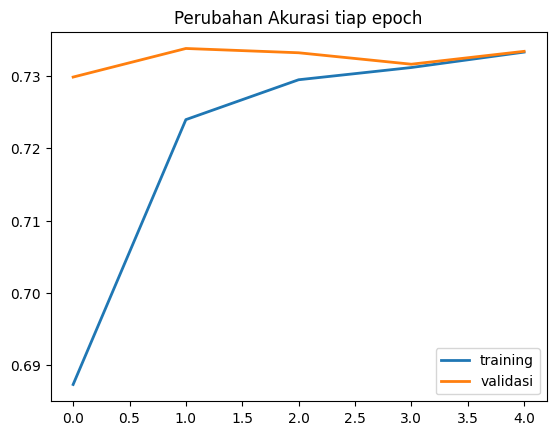

158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Classification Report :
              precision    recall  f1-score   support

           0   0.678386  0.882657  0.767156      2514
           1   0.834456  0.585664  0.688267      2539

    accuracy                       0.733426      5053
   macro avg   0.756421  0.734160  0.727712      5053
weighted avg   0.756807  0.733426  0.727516      5053



In [14]:
result = []
result.append(hybrid_lstm_cnn(x_train, y_train, x_test, y_test))
result.append(hybrid_lstm_cnn(x_train, y_train, x_test, y_test))
result.append(hybrid_lstm_cnn(x_train, y_train, x_test, y_test))

In [15]:
average = np.mean(result, axis=0, dtype=float)
print('Average Accuracy  :', average[0])
print('Average Precision :', average[1])
print('Average Recall    :', average[2])
print('Average F1-Score  :', average[3])

Average Accuracy  : 0.7328979484134838
Average Precision : 0.830877024232667
Average Recall    : 0.5881580674806354
Average F1-Score  : 0.688753192576447
